In [52]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import Embedding, LSTM, Linear
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt

from random import shuffle

import re
import pymorphy2

import time

import json

from tqdm import tqdm

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Загрузка датасета

In [4]:
train_df = pd.read_csv('datasets/Training_data_marked.csv')
test_df = pd.read_csv('datasets/Test_data_marked.csv')
df = pd.concat([train_df, test_df], ignore_index=True)
df

,Общая оценка,Цена/качество,Расположение,Качество сна,Номера,Чистота,Обслуживание,Текст отзыва
0,4,4.0,4.0,5.0,4.0,4.0,5.0,"Очень достойный отель с прекрасными номерами, ..."
1,4,NaN,3.0,NaN,NaN,4.0,4.0,"Остановились в Барселоне проездом, т.к. нужно ..."
2,4,3.0,3.0,5.0,5.0,3.0,4.0,Типичная сетевая гостиница. Главный плюс-шикар...
3,1,NaN,NaN,NaN,2.0,1.0,1.0,"Начнем с того, что в этом отеле не берут деньг..."
4,5,NaN,NaN,NaN,NaN,NaN,NaN,"Отель находится в отдалении от центра,но пешко..."
...,...,...,...,...,...,...,...,...
57199,5,4.0,4.0,5.0,5.0,4.0,5.0,"Для нас было плюсом, что в этом отеле можно ос..."
57200,5,5.0,4.0,5.0,5.0,5.0,5.0,Очень понравился отель.Хорошие номера с кухней...
57201,5,5.0,4.0,5.0,5.0,5.0,4.0,"В Петербурге бываю очень часто, поэтому появле..."
57202,5,5.0,5.0,5.0,5.0,5.0,5.0,Изумительное место! Я просто не ожидала такого...


In [5]:
df = df.rename(columns={'Текст отзыва': 'text', 'Общая оценка': 'score'})
df = df[['score', 'text']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57204 entries, 0 to 57203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   score   57204 non-null  int64 
 1   text    57053 non-null  object
dtypes: int64(1), object(1)
memory usage: 893.9+ KB


In [6]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57039 entries, 0 to 57203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   score   57039 non-null  int64 
 1   text    57039 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [8]:
def draw_statistics(df):
    x = df.groupby(by='score').count()
    plt.pie(x['text'], labels=x.index,  autopct='%.1f')
    plt.title('Соотношение оценок в коментариях')
    print(x['text'])

score
1     1452
2     2026
3     6356
4    18208
5    28997
Name: text, dtype: int64


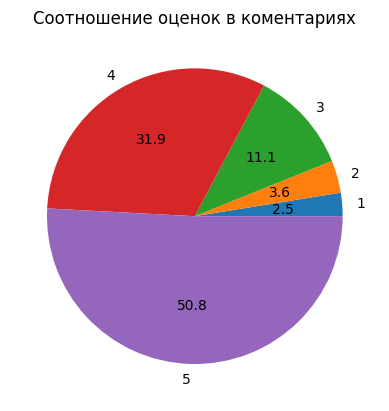

In [9]:
draw_statistics(df)

# Просмотр отзывов

In [9]:
def get_reviews(score, len_):
    idx = list(df[df['score'] == score].index)
    shuffle(idx)
    return list(df['text'][idx[:len_]])

In [16]:
for i in range(1, 6):
    print('Оценка:', i, get_reviews(i, 3), end='\n\n')

Оценка: 1 ['Каждый кубический сантиметр воздуха в отеле пропитан невыносимой наимерзейшей вонью кошачьей, пёсьей, волчьей, медвежьей и слоновьей ссанины. Чтобы получилось уснуть, пришлось курить в номере - только так запах прятался на несколько минут. И это не смотря на расположение кровати прямо рядом с открытым настежь окном.Есть множество и других огромнейших минусов, но они все меркнут в сравнении с вонью.', 'Останавливались в отеле вдвоем с мужем в июне 2014 года. Заказали номер как было заявлено на сайте высшей категории. Сразу напрягло, что номер оказался напротив лифта и был смежным (видимо он подразумевался как двухкомнатный, просто дверь во вторую комнату закрывается на ключ). Как по заказу в этот смежный номер поселили семейную пару с маленьким ребенком, который конечно плакал по ночам, ломился в эту закрытую дверь в коридоре и просыпался в пять утра. Но на все это можно было бы закрыть глаза, у нас тоже были маленькие дети, закрывали поплотнее дверь в прихожую и спали. Само

# Балансировка данных

In [11]:
s = [len(df[df['score']==i]) for i in range(1, 6)]
s, s[0]+s[1], (s[0]+s[1])/2

([1452, 2026, 6356, 18208, 28997], 3478, 1739.0)

In [12]:
df_b = pd.concat([df[df['score']==i][:s[0]] for i in range(1, 6) if i != 3])

score
1    1452
2    1452
4    1452
5    1452
Name: text, dtype: int64


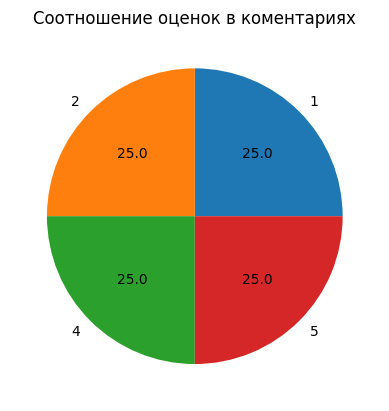

In [13]:
draw_statistics(df_b)

# Обработка текста

In [12]:
def clear_text(text):
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text) # Удаление ссылок
    text = re.sub('"[\S]+"', '', text) # Удаление названий. Пример: "ООО ..."
    text = text.lower().replace("ё", "е")

    for i in list('.?!()') + ['...']:
        text = text.replace(i, ' ') # В конце строки часто не ставят пробелов
        # из-за этого после обработки два слова склеиваются и перестают нести смысловую нагрузку для сети
    
    symbols = re.findall("[а-я\s]", text) # Оставляем только буквы
    text = ''.join(symbols)
    text = re.sub(' +', ' ', text) # Оставляем между словами 1 пробел
    return text.strip()

In [13]:
morph = pymorphy2.MorphAnalyzer(lang='ru')

def stemming(text):
    text = text.split()
    new_text = []

    for i in text:
        tmp = morph.parse(i)[0]
        if not 'UNKN' in tmp.tag: # Если слово написано с ошибкой или несуществующее слово
            new_text.append(tmp.normal_form)
    
    return ' '.join(new_text)

In [8]:
def preprocess_text(text):
    text = clear_text(text)
    text = stemming(text)
    return text

In [38]:
i = 1
print(df_b['text'][i], end='\n\n')
print(preprocess_text(df_b['text'][i]))

Остановились в Барселоне проездом, т.к. нужно было посетить консульство РФ. Расположение, для посещения консульства - неплохо, дошли до него пешком (хотя идти пришлось минут 25 и в горку). Сама гостиница - достаточно хороша, завтрак - замечательный. В гостинице подземная парковка - заезжать туда нужно сразу, хотя она и рядом с главным входом (погуглите стрит вью) и на самый нижний уровень. У нас машина высокая (2м), но потолки парковки достаточно высокие и проблемы не было. Оттуда с вещами на лифте - в лобби. Есть достаточно простенький но функциональный спорт зал. Номера - нормальные, в принципе все понравилось.

остановиться в барселона проезд так к нужно быть посетить консульство рф расположение для посещение консульство неплохо дойти до он пешком хотя идти прийтись минута и в горка сам гостиница достаточно хороший завтрак замечательный в гостиница подземный парковка заезжать туда нужно сразу хотя она и рядом с главный вход погуглита стрит вить и на самый нижний уровень у мы машина 

In [17]:
df_pre = df_b.copy()
df_pre['text'] = df_pre['text'].map(lambda x: preprocess_text(x))

In [18]:
df_pre.to_csv('datasets/preprocess_ds.csv')

In [88]:
df_pre =  pd.read_csv('datasets/preprocess_ds.csv', index_col=0)

In [22]:
df_pre['text'] = df_pre['text'].map(lambda x: str(x))

# Токенизация

In [23]:
unique_words = set(' '.join(df_pre['text']).split())
tokens = {value: key for key, value in enumerate(unique_words, start=1)}
print('Количество токенов:', len(tokens))

Количество токенов: 22687


In [24]:
with open('datasets/vocabulary.json', 'w') as f:
    json.dump(tokens, f)

In [ ]:
with open('datasets/vocabulary.json', 'r') as f:
    tokens = json.load(f)

In [10]:
def text2numbers(text, dict_): 
    text = text.split()
    sequence = []

    for i in text:
        if i in dict_.keys():
            sequence.append(dict_[i])

    return sequence

In [9]:
def texts2tokens(row):
    return [text2numbers(i, dict_=tokens) for i in row]

In [27]:
texts = texts2tokens(df_pre['text'])

## Преобразовываем тексты к одной длине

In [28]:
text_len = [len(i) for i in texts]

print('Количество слов:')
print('Min:', np.min(text_len))
print('Max:', np.max(text_len))
print('Mean:', np.mean(text_len))
print('Median:', np.median(text_len))

Количество слов:
Min: 1
Max: 1623
Mean: 104.70609504132231
Median: 74.0


In [15]:
def set_text_len(texts, max_len):
    array = np.zeros([len(texts), max_len])

    i = 0
    for value in texts:
        tmp = max_len-len(value)
        tmp = tmp if tmp > 0 else 0

        text = np.concatenate((value[:max_len], np.zeros(tmp)))
        array[i] = text
        i+=1

    return array 

In [30]:
max_len = 80
texts_same_len = set_text_len(texts, max_len)

texts_same_len.shape

(5808, 80)

In [31]:
np.save('datasets/texts_same_len.npy', texts_same_len)

In [25]:
texts_same_len = np.load('datasets/texts_same_len.npy')

## Преобразование результирующей колонки

In [32]:
df_pre['score'].unique()

array([1, 2, 4, 5])

In [90]:
def rules(row):
    score = row['score']
    new_score = -1

    if score in [4, 5]:
        new_score = 5 # Положительные
    elif score in [1, 2]:
        new_score = 1 # Отрицательные


    row['score'] = new_score
    return row

def merge_categories(df):
    return df.apply(rules, axis=1)

In [91]:
df_pre = merge_categories(df_pre)

In [92]:
score_enc = OneHotEncoder(handle_unknown='ignore')
X = df_pre['score'].to_numpy().reshape(-1, 1)

unique_items = np.unique(X).reshape(-1, 1)
score_enc.fit(unique_items)

print('Категории:', score_enc.categories_, sep='\n')
print()
for i, desc in zip(score_enc.categories_[0], ['Отрицательные\t', 'Положительные\t']):
    print(desc, i, score_enc.transform(np.array([i]).reshape(-1, 1)).toarray())

Категории:
[array([1, 5])]

Отрицательные	 1 [[1. 0.]]
Положительные	 5 [[0. 1.]]


In [36]:
def score_one_hot_encoder(row):
    array = row.to_numpy().reshape(-1, 1)
    return score_enc.transform(array).toarray()

In [37]:
score = score_one_hot_encoder(df_pre['score'])

In [38]:
np.save('datasets/score.npy', score)

In [24]:
score = np.load('datasets/score.npy')

# Создание DataLoader

In [26]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.IntTensor(self.X[idx]), torch.IntTensor([self.y[idx]])

In [40]:
len(score)

5808

In [27]:
len_ = 8

if len_ != 0:
    train_score = score[:-len_]
    train_texts_same_len = texts_same_len[:-len_]
else:
    train_score = score
    train_texts_same_len = texts_same_len

print('Data', train_score.shape, train_texts_same_len.shape)

Data (5800, 2) (5800, 80)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(train_texts_same_len, train_score, test_size=0.20, random_state=87)
len(X_train), len(X_test)

(4640, 1160)

In [29]:
batch_size = 20

train = TextDataset(X_train, y_train)
test = TextDataset(X_test, y_test)

train_loader = DataLoader(train,  batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [45]:
x, y = next(iter(train))
x.shape, y.shape, y #, x

(torch.Size([80]), torch.Size([1, 2]), tensor([[1, 0]], dtype=torch.int32))

In [46]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([20, 80]), torch.Size([20, 1, 2]))

# Создание модели

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.embedding = Embedding(input_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers=2, batch_first=True, dropout=0.25)
        self.fc = Linear(hidden_size, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)

        output = self.fc(output[:, -1, :])
        output = self.sig(output).reshape(-1, 1, self.output_size)
       
        return output

In [95]:
e = Embedding(10, 3)
e(torch.IntTensor([1, 2, 3, 1]))

tensor([[ 0.9233, -0.2279, -0.3224],
        [ 1.4868,  0.8123,  0.2109],
        [ 0.1834,  0.0880,  0.3074],
        [ 0.9233, -0.2279, -0.3224]], grad_fn=<EmbeddingBackward0>)

In [52]:
model = LSTM(input_size=len(tokens) + 1,
            embedding_dim=256,
            hidden_size=512,
            output_size=2
)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

print(model)

LSTM(
  (embedding): Embedding(22688, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=512, out_features=2, bias=True)
  (sig): Sigmoid()
)


In [4]:
def accuracy(model, data_loader, device):
    correct = 0
    
    with torch.no_grad():
        for i, (X, y) in enumerate(data_loader):
            X = X.to(device)
            y = y.float().to(device)
            outputs = model(X)

            for pred, target in zip(outputs, y):
                correct += pred.argmax() == target.argmax()
                
        total = len(data_loader) * data_loader.batch_size
        print(total, correct)
    return correct.float()/total * 100 

In [50]:
def train(model, epochs = 10, prefix='e'):
    start = time.time()
    acc_score = {'train': [], 'test': []}
    
    for epoch in range(epochs):
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            text, labels = data
            text = text.to(device)
            labels = labels.to(device)
    
        
            optimizer.zero_grad()
            outputs = model(text)
            loss = loss_fn(outputs, labels.float())
            loss.backward()
            optimizer.step()

        torch.save(model, f'models/{prefix}{epoch}_lstm.pt')
    
        with torch.set_grad_enabled(False):
            train_acc = accuracy(model, train_loader, device)
            test_acc = accuracy(model, test_loader, device)
            
            acc_score['train'].append(train_acc)
            acc_score['test'].append(test_acc)
            
            tqdm.write(f'Train accuracy: {train_acc:.2f}%')
            tqdm.write(f'Test accuracy: {test_acc:.2f}%')
   
        
    print(f'Total time: {(time.time() - start)/60:.2f} min')
    print(f'Test accuracy: {accuracy(model, test_loader, device):.2f}%')

    return acc_score

In [53]:
acc_score = train(model)

100%|█████████████████████████████████████████| 232/232 [00:07<00:00, 32.17it/s]


4640 tensor(2734, device='cuda:0')
1160 tensor(685, device='cuda:0')
Train accuracy: 58.92%
Test accuracy: 59.05%


100%|█████████████████████████████████████████| 232/232 [00:06<00:00, 33.46it/s]


4640 tensor(2911, device='cuda:0')
1160 tensor(723, device='cuda:0')
Train accuracy: 62.74%
Test accuracy: 62.33%


100%|█████████████████████████████████████████| 232/232 [00:06<00:00, 33.45it/s]


4640 tensor(3336, device='cuda:0')
1160 tensor(834, device='cuda:0')
Train accuracy: 71.90%
Test accuracy: 71.90%


100%|█████████████████████████████████████████| 232/232 [00:06<00:00, 33.42it/s]


4640 tensor(4031, device='cuda:0')
1160 tensor(982, device='cuda:0')
Train accuracy: 86.88%
Test accuracy: 84.66%


100%|█████████████████████████████████████████| 232/232 [00:06<00:00, 33.27it/s]


4640 tensor(4265, device='cuda:0')
1160 tensor(1020, device='cuda:0')
Train accuracy: 91.92%
Test accuracy: 87.93%


100%|█████████████████████████████████████████| 232/232 [00:06<00:00, 33.39it/s]


4640 tensor(4338, device='cuda:0')
1160 tensor(1027, device='cuda:0')
Train accuracy: 93.49%
Test accuracy: 88.53%


100%|█████████████████████████████████████████| 232/232 [00:06<00:00, 33.37it/s]


4640 tensor(4410, device='cuda:0')
1160 tensor(1046, device='cuda:0')
Train accuracy: 95.04%
Test accuracy: 90.17%


100%|█████████████████████████████████████████| 232/232 [00:07<00:00, 32.98it/s]


4640 tensor(4466, device='cuda:0')
1160 tensor(1040, device='cuda:0')
Train accuracy: 96.25%
Test accuracy: 89.66%


100%|█████████████████████████████████████████| 232/232 [00:06<00:00, 33.30it/s]


4640 tensor(4524, device='cuda:0')
1160 tensor(1060, device='cuda:0')
Train accuracy: 97.50%
Test accuracy: 91.38%


100%|█████████████████████████████████████████| 232/232 [00:06<00:00, 33.30it/s]


4640 tensor(4537, device='cuda:0')
1160 tensor(1056, device='cuda:0')
Train accuracy: 97.78%
Test accuracy: 91.03%
Total time: 1.70 min
1160 tensor(1058, device='cuda:0')
Test accuracy: 91.21%


In [54]:
def to_list(tensors):
    return [i.cpu().item() for i in tensors]

Text(0.5, 1.0, 'Accuracy')

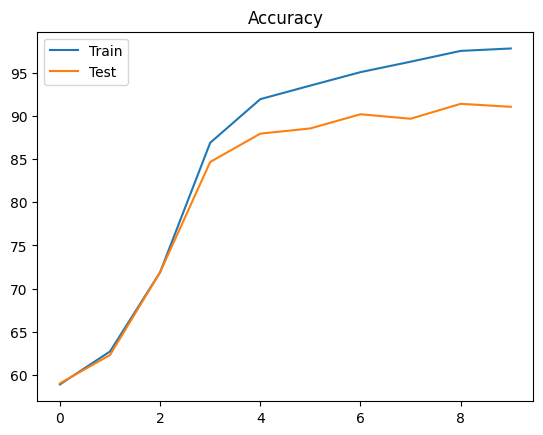

In [55]:
train = to_list(acc_score['train'])
test = to_list(acc_score['test'])

plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.legend()
plt.title('Accuracy')

In [59]:
with open('datasets/acc.json', 'w') as f:
    json.dump({'train': train, 'test': test}, f)

In [5]:
model1 = torch.load('models/e6_lstm.pt', weights_only=False)
model1.eval()

LSTM(
  (embedding): Embedding(22688, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=512, out_features=2, bias=True)
  (sig): Sigmoid()
)

In [6]:
tokens = {}
with open('datasets/vocabulary.json', 'r') as f:
    tokens = json.load(f)

def predict(texts):
    texts = [preprocess_text(i) for i in texts]
    num_text = texts2tokens(texts)
    max_len = [len(i) for i in num_text]
    same_shape = set_text_len(num_text, max(max_len))
    tensors = torch.IntTensor(same_shape).to(device)

    pred = []
    for i in model1(tensors):
        tmp = i.cpu().argmax()
        # print(tmp)
        tmp = 5 if tmp == 1 else 1
        pred.append(tmp)
    
    return pred

In [22]:
predict(['хороший отель, но есть нюансы', 'очень шумно на улице не возможно спать по ночам', 
         'плохой отель', 'На весь отель 3 или 4 фена, которые надо просить на ресепшене,\
         если успеешь. Это очень странно. Забирайте с вечера, если нужен вам.',
        'очень не понравилось, что время бежит чертовски быстро. И приближение рабочих дней крайне не понравилось!',
        '"Я останавливался в этом отеле на выходные, и, к сожалению, мой опыт был далеко не положительным. Номер\
        оказался грязным, с пылью на мебели и неубранной ванной. Персонал был не очень дружелюбным и не реагировал\
        на наши просьбы. Завтрак тоже разочаровал: еда была холодной и не свежей. Я не рекомендую этот отель, так \
        как за такие деньги можно найти гораздо лучшие варианты.', 'Я провел замечательные дни в этом отеле! Номер \
        был чистым и уютным, с прекрасным видом на город. Персонал был очень вежливым и отзывчивым, всегда готов\
        помочь. Завтрак был разнообразным и вкусным, особенно понравились свежие булочки и кофе. Я обязательно\
        вернусь сюда снова и рекомендую всем, кто ищет комфортное место для отдыха!'])

[5, 1, 1, 1, 1, 1, 5]

In [38]:
def get_pred_y(model, data_loader, device):
    outputs = []
    correct = []
    
    with torch.no_grad():
        for i, (X, y) in enumerate(data_loader):
            X = X.to(device)
            outputs.extend(model(X))
            correct.extend(y)

    outputs = [i.cpu().argmax().item() for i in outputs]
    correct = [i.cpu().argmax().item() for i in correct]
    
    return outputs, correct 

In [50]:
predicted, y_test = get_pred_y(model1, test_loader, device)

accuracy_score = metrics.accuracy_score(predicted, y_test)

print(f'Model accuracy = {accuracy_score*100:4.2f}%\n')
print('Classification Report:')
print(metrics.classification_report(y_test, predicted))

Model accuracy = 90.26%

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       593
           1       0.95      0.85      0.90       567

    accuracy                           0.90      1160
   macro avg       0.91      0.90      0.90      1160
weighted avg       0.91      0.90      0.90      1160



Text(0.5, 1.0, 'Confusion Matrix')

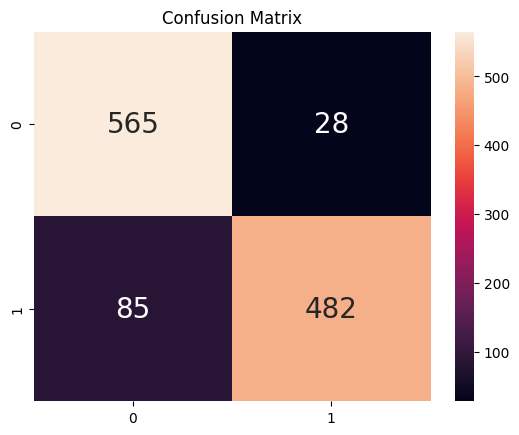

In [69]:
cm = pd.DataFrame(metrics.confusion_matrix(y_test, predicted))
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, fmt='.0f')
plt.title('Confusion Matrix')

In [73]:
cm[1][0], cm[1][1]

(np.int64(28), np.int64(482))

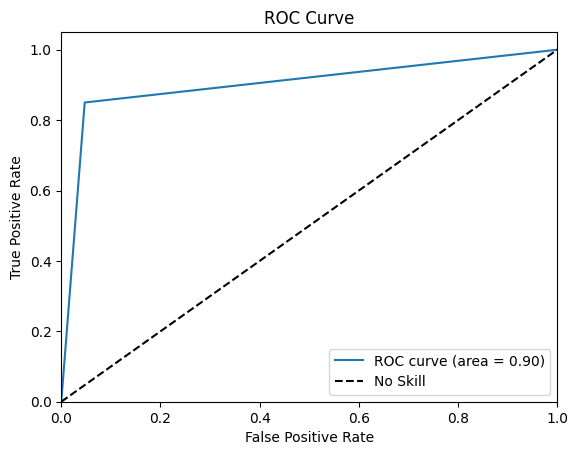

In [86]:
#  TPR = TP/(TP+FN)
# FPR = FP/(FP+TN)

tpr = cm[0][0]/(cm[0][0]+cm[0][1])
fpr = cm[1][0]/(cm[1][0]+cm[1][1])


fpr, tpr, thresholds = metrics.roc_curve(y_test, predicted) 
roc_auc = metrics.auc(fpr, tpr)

plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()